In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

# Logistic regression

In [2]:
# https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/
df = pd.read_csv("../data/ucla_sample.csv")
df.head()

,female,read,write,math,hon,femalexmath
0,0,57,52,41,0,0
1,1,68,59,53,0,53
2,0,44,33,54,0,0
3,0,63,44,47,0,0
4,0,47,52,57,0,0


In [3]:
df.groupby('female').agg({'hon': np.mean})

,hon
female,
0,0.186813
1,0.293578


In [4]:
model = LogisticRegression(solver='lbfgs', C=1e9).fit(df['female'].values.reshape(-1, 1), df['hon'])
model.intercept_[0], model.coef_

(-1.4708506685694538, array([[0.59278117]]))

In [5]:
# reference group is female=0
female = 0
p_success_men = 1/(1+np.exp(-(model.intercept_[0] + model.coef_[0][0]*female)))
female = 1
p_success_women = 1/(1+np.exp(-(model.intercept_[0] + model.coef_[0][0]*female)))

print('p(success|male)=', p_success_men, '\np(success|female)=', p_success_women)

p(success|male)= 0.18681335096826626 
p(success|female)= 0.2935779853642987


In [6]:
odds_men = p_success_men/(1-p_success_men)
odds_women = p_success_women/(1-p_success_women)
odds_men, odds_women

(0.22972997797087058, 0.41558442302466403)

In [7]:
odds_ratio_female_male = odds_women/odds_men
odds_ratio_female_male  # odds for females ~81% higher than for men (= np.exp(model.coef_[0][0]) = odds(female+1)/odds(female) = exp(b1))

1.809012592502662

In [8]:
# import statsmodels.formula.api as sm
# model = sm.Logit(df['hon'], df['female'].values.reshape(-1, 1))
# result = model.fit()
# print(result.summary())

# # module imports
# from patsy import dmatrices
# import pandas as pd
# from sklearn.linear_model import LogisticRegression
# import statsmodels.discrete.discrete_model as sm

# # read in the data & create matrices
# df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
# y, X = dmatrices('admit ~ gre + gpa + C(rank)', df, return_type = 'dataframe')

# # sklearn output
# model = LogisticRegression(fit_intercept = False, C = 1e9)
# mdl = model.fit(X, y)
# model.coef_

# # sm
# logit = sm.Logit(y, X)
# logit.fit().params

---

---

## Another dataset containing a study about cervical cancer

In [9]:
# https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29
df = pd.read_csv("../data/risk_factors_cervical_cancer.csv")
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [10]:
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [11]:
# df['STDs (number)'].value_counts()
df = df.loc[df['Smokes'] != '?']
df = df.loc[df['STDs (number)'] != '?']
df = df.loc[df['Hormonal Contraceptives'] != '?']

df['Biopsy'].mean()

0.07103825136612021

In [12]:
df.groupby('Smokes').agg({'Biopsy': np.mean})

,Biopsy
Smokes,
0.0,0.066986
1.0,0.095238


In [13]:
def _numeric_transformer(X):
    return pd.DataFrame([X]).T

col_encoders = {
    'Smokes': Pipeline(
                # StandardScaler needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),]
                #('scaler', OneHotEncoder(categories='auto'))]
    ),
#     'STDs (number)': Pipeline(
#                 # StandardScaler needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),
#                  ('scaler', OneHotEncoder(categories='auto'))]
#     )
}

columns = col_encoders.keys()

transformers = ColumnTransformer([(col, col_encoders[col], col) for col in columns])

estimator = LogisticRegression(solver='lbfgs')

model = Pipeline([('transformers', transformers), ('estimator', estimator)])
model

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('Smokes', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _nume...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [14]:
model.fit(df[columns], df['Biopsy'])

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('Smokes', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _nume...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [15]:
b0 = model.named_steps['estimator'].intercept_[0]
b1 = model.named_steps['estimator'].coef_[0][0]

# reference group are non-smokers
smokes = 0
p_success_nonsmoker = 1/(1+np.exp(-(b0 + b1*smokes)))
smokes = 1
p_success_smoker = 1/(1+np.exp(-(b0 + b1*smokes)))

print('p(success|nonsmoker)=', p_success_nonsmoker, '\np(success|smoker)=', p_success_smoker)

p(success|nonsmoker)= 0.06752216111043656 
p(success|smoker)= 0.09203495866602045


In [16]:
odds_nonsmoker = p_success_nonsmoker/(1-p_success_nonsmoker)
odds_smoker = p_success_smoker/(1-p_success_smoker)
odds_nonsmoker, odds_smoker

(0.07241154512673993, 0.10136398922452229)

In [17]:
odds_ratio_smoker_non_smoker = odds_smoker/odds_nonsmoker
odds_ratio_smoker_non_smoker  # odds for smokers ~40% higher than for non-smokers

1.399831878288299

---

# Decision trees

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

df = pd.read_csv("../data/risk_factors_cervical_cancer.csv")
df = df.loc[df['Smokes'] != '?']
df = df.loc[df['STDs (number)'] != '?']
df = df.loc[df['Hormonal Contraceptives'] != '?']

def _numeric_transformer(X):
    return pd.DataFrame([X]).T

col_encoders = {
    'Smokes': Pipeline(
                # StandardScaler needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),
                ('scaler', OneHotEncoder(categories='auto'))]
    ),
    'STDs (number)': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),
                 ('scaler', OneHotEncoder(categories='auto'))]
    )
}

columns = col_encoders.keys()

transformers = ColumnTransformer([(col, col_encoders[col], col) for col in columns])

estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3, class_weight='balanced')

model = Pipeline([('transformers', transformers), ('estimator', estimator)])
model

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('Smokes', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _nume...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [19]:
model.fit(df[columns], df['Biopsy'])

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('Smokes', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _nume...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [20]:
export_graphviz(model.named_steps['estimator'], 'decision_tree.dot', proportion=True, rotate=True)
# sudo apt install graphviz
! dot -Tpng decision_tree.dot -o decision_tree.png
! ls

classification.ipynb  decision_tree.dot  decision_tree.png  regression.ipynb


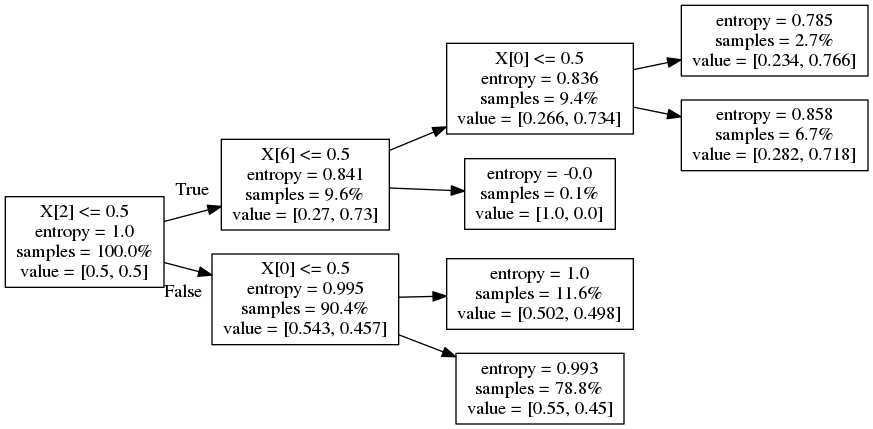

In [21]:
from IPython.display import Image
Image(filename='decision_tree.png')

In [22]:
print(classification_report(df.Biopsy, model.predict(df[columns])))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       680
           1       0.17      0.23      0.20        52

   micro avg       0.87      0.87      0.87       732
   macro avg       0.56      0.57      0.56       732
weighted avg       0.89      0.87      0.88       732



In [23]:
df.groupby('Smokes').agg({'Biopsy': np.mean})

,Biopsy
Smokes,
0.0,0.066986
1.0,0.095238


In [24]:
-0.55*np.log2(0.55) - 0.45*np.log2(0.45)

0.9927744539878083